Winter Semester 2020/21, M.Sc. Economics | University of Bonn | [Madhurima Chandra](https://github.com/mchandra12)

# Testing optimization algorithms supported in estimagic - Scientific Computing Project

This notebook presents an overview of my project on extending the testing suite for optimization algorithms supported in the python package [estimagic](https://github.com/OpenSourceEconomics/estimagic). Benchmarking the algorithms against three critical functions - trid, rotated hyper ellipsoid and rosenbrock and also ten different types of constraints, we discuss how different optimization algorithms perform in terms of accuracy. Additionally, in this notebook I also consider their performance with respect to number of criterion evaluations required to reach the optima. This project involved primarily three steps, and my contributions are organized into three corresponding files linked below.

Links to code files and documentation that together form the core of my project (please view them in this order):
1. [Implement benchmark functions for testing of algorithms](https://github.com/OpenSourceEconomics/estimagic/blob/new_tests_optimization/estimagic/examples/criterion_functions_optimization_tests.py)
2. [Write test functions using the pytest (specially pytest.mark.parametrize) framework](https://github.com/OpenSourceEconomics/estimagic/blob/new_tests_optimization/estimagic/tests/optimization/test_other_criterion_functions.py)
3. [Add a section to estimagic's documentation on the testing of optimization algorithms](https://github.com/OpenSourceEconomics/estimagic/blob/new_tests_optimization/docs/source/explanations/optimization/tests_for_supported_optimizers.rst)

All the above files are located in the branch called ``new_tests_optimization`` in estimagic, see [here](https://github.com/OpenSourceEconomics/estimagic/tree/new_tests_optimization).

In [5]:
import numpy as np
import pandas as pd

In [1]:
# from estimagic.config import IS_DFOLS_INSTALLED
# from estimagic.config import IS_PYBOBYQA_INSTALLED

In [2]:
from estimagic.examples.criterion_functions_optimization_tests import (
    rosenbrock_criterion_and_gradient,
)
from estimagic.examples.criterion_functions_optimization_tests import (
    rosenbrock_dict_criterion,
)
from estimagic.examples.criterion_functions_optimization_tests import (
    rosenbrock_gradient,
)
from estimagic.examples.criterion_functions_optimization_tests import (
    rosenbrock_pandas_gradient,
)
from estimagic.examples.criterion_functions_optimization_tests import (
    rosenbrock_scalar_criterion,
)
from estimagic.examples.criterion_functions_optimization_tests import (
    rotated_hyper_ellipsoid_criterion_and_gradient,
)
from estimagic.examples.criterion_functions_optimization_tests import (
    rotated_hyper_ellipsoid_dict_criterion,
)
from estimagic.examples.criterion_functions_optimization_tests import (
    rotated_hyper_ellipsoid_gradient,
)
from estimagic.examples.criterion_functions_optimization_tests import (
    rotated_hyper_ellipsoid_pandas_gradient,
)
from estimagic.examples.criterion_functions_optimization_tests import (
    rotated_hyper_ellipsoid_scalar_criterion,
)
from estimagic.examples.criterion_functions_optimization_tests import (
    trid_criterion_and_gradient,
)
from estimagic.examples.criterion_functions_optimization_tests import (
    trid_dict_criterion,
)
from estimagic.examples.criterion_functions_optimization_tests import trid_gradient
from estimagic.examples.criterion_functions_optimization_tests import (
    trid_pandas_gradient,
)
from estimagic.examples.criterion_functions_optimization_tests import (
    trid_scalar_criterion,
)
from estimagic.optimization.optimize import maximize
from estimagic.optimization.optimize import minimize

## Table of Contents

[1. Implement benchmark functions for testing of algorithms](#sec1) 

 - [1.1 Trid function](#sec11)
 - [1.2 Rotated Hyper Ellipsoid function](#sec12)
 - [1.3 Rosenbrock function](#sec13)

[2. Write test functions using the pytest.mark.parametrize framework](#sec2)

 - [2.1 Analytical solutions to all optimization problems considered in the project](#sec21)
 - [2.2 Algorithms considered](#sec22)
 - [2.3 What we learnt from the tests](#sec23)

[3. Additional Visualizations: Compare algorithms on criterion-evaluations](#sec4)
 - [3.1 Case 1: No constraints ](#sec31)
 - [3.2 Case 2: Imposing Equality constraint](#sec32)
 - [3.3 Case 3: Imposing Linear constraint](#sec33)
 
[4. Summary of contributions](#sec5)

---
<a id='sec1'></a>
# 1. Implement benchmark functions for testing of algorithms 
---

We implement each function and its gradient in different ways, taking
into account the types of objective functions that estimagic's
``minimize`` and ``maximize`` accepts  for optimization. All algorithms accept
criterion functions specified in a dictionary, while a subset also accept the criterion
specified in scalar form. Likewise, if specified, the gradient of a criterion can be
an np.ndarray or a pandas object. We test for all possible cases.
For instance, for rotated hyper ellipsoid, we implement the following functions:

* rotated_hyper_ellipsoid_scalar_criterion
* rotated_hyper_ellipsoid_dict_criterion: This provides a dictionary wherein the
  ``contributions`` and ``root_contributions`` keys present the criterion as a least
  squares problem, relevant when we are testing a least squares algorithm.
* rotated_hyper_ellipsoid_gradient
* rotated_hyper_ellipsoid_pandas_gradient: Computes the gradient of the rotated hyper
  ellipsoid function, as a pandas object.
* rotated_hyper_ellipsoid_criterion_and_gradient

The code block below serves as an illustrative example for one criterion. All other function implementations can be found in the ``examples`` directory, in ``criterion_functions_optimization_tests.py``.

In [92]:
def rotated_hyper_ellipsoid_scalar_criterion(params):
    """ Implement Rotated Hyper Ellipsoid function.
    Function description: https://www.sfu.ca/~ssurjano/rothyp.html.
    
    Args:
        params (pd.DataFrame): Must have the column "value" containing
        input values for parameters. Accepts arbitrary numbers of input values.
        
    Returns:
        int: Rotated Hyper Ellipsoid function output.
    """
    val = 0
    for i in range(len(params["value"])):
        val += (params["value"][: i + 1] ** 2).sum()
    return val


def rotated_hyper_ellipsoid_gradient(params):
    """Calculate gradient of rotated_hyper_ellipsoid function.
    
    Args:
        params(pandas.DataFrame): Must have the column "value" containing
        input values for parameters. Accepts arbitrary numbers of input values.
    
    Returns:
        np.ndarray: gradient of rotated hyper ellipsoid function.
    """
    
    x = params["value"].to_numpy()
    return np.arange(2 * len(x), 0, -2) * x


def rotated_hyper_ellipsoid_pandas_gradient(params):
    """Calculate gradient of rotated_hyper_ellipsoid function.
    
    Args:
        params(pandas.DataFrame): Must have the column "value" containing
        input values for parameters. Accepts arbitrary numbers of input values.
    
    Returns:
        pd.Series: gradient of rotated hyper ellipsoid function.
    """
    x = params["value"].to_numpy()
    return pd.Series(np.arange(2 * len(x), 0, -2) * x)


def rotated_hyper_ellipsoid_criterion_and_gradient(params):
    """ Implement Rotated Hyper Ellipsoid function and calculate gradient.
    Function description: https://www.sfu.ca/~ssurjano/rothyp.html.
    
    Args:
        params (pd.DataFrame): Must have the column "value" containing
        input values for parameters. Accepts arbitrary numbers of input values.
        
    Returns:
        int: Rotated Hyper Ellipsoid function output.
        np.ndarray: gradient of rotated hyper ellipsoid function.
    """
    val = 0
    for i in range(len(params["value"])):
        val += (params["value"][: i + 1] ** 2).sum()
    x = params["value"].to_numpy()
    return val, np.arange(2 * len(x), 0, -2) * x


def rotated_hyper_ellipsoid_contributions(params):
    """ Compute contributions of Rotated Hyper Ellipsoid function.
    
    Args:
        params (pd.DataFrame): Must have the column "value" containing
        input values for parameters. Accepts arbitrary numbers of input values.
        
    Returns:
        np.ndarray: array with contributions of function output as elements.
    """
    x = params["value"].to_numpy()
    dim = len(params)
    out = np.zeros(dim)
    for i in range(dim):
        out[i] = (x[: i + 1] ** 2).sum()
    return out


def rotated_hyper_ellipsoid_dict_criterion(params):
    """Implement Rotated Hyper Ellipsoid function and compute
        contributions and root_contributions.
    
    Args:
        params(pandas.DataFrame): Must have the column "value" containing
        input values for parameters. Accepts arbitrary numbers of input values.
    
    Returns:
        Dictionary with the following entries:
        "value" (a scalar float): rotated hyper ellipsoid function output.
        "contributions" (np.ndarray): array with contributions of function output as elements.
        "root_contributions" (np.ndarray): array with root of contributions of function output as elements. 
    """
    out = {
        "value": rotated_hyper_ellipsoid_scalar_criterion(params),
        "contributions": rotated_hyper_ellipsoid_contributions(params),
        "root_contributions": np.sqrt(rotated_hyper_ellipsoid_contributions(params)),
    }
    return out


---
<a id='sec11'></a>
## 1.1 Trid function
---

add gradients

---
<a id='sec12'></a>
## 1.2 Rotated Hyper Ellipsoid function
---

add gradients

---
<a id='sec13'></a>
## 1.3 Rosenbrock function
---

add gradients

---
<a id='sec2'></a>
# 2. Write test functions using the pytest.mark.parametrize framework
---

For testing the external interface, we write several test functions, each considers the
case of one constraint. Given the constraint, the test function considers all possible
combinations of - algorithm, to maximize or to minimize, criterion function
implementation, gradient function implementation for that criterion (if provided),
and whether ``criterion_and_derivative`` has been provided or not. 

In total, the file test_other_criterion_functions.py runs **3620 test cases** (10 test functions, each function running 362 test cases). 
The best way to visualize these tests 'in action' is to call ``pytest test_other_criterion_functions.py`` in the terminal, after switching to the correct directory.

Below we show the calculations behind the true values, for each testcase (one criterion
and one constraint). The test functions compare these values with the solutions returned
by the algorithms, for each corresponding testcase.

---
<a id='sec21'></a>
## 2.1 Analytical solutions to all optimization problems considered in the project
---

---
<a id='sec22'></a>
## 2.2 Algorithms considered
---

---
<a id='sec23'></a>
## 2.3 What we learnt from the tests
---

* hhh
* ggg
* 
* 
* 

---
<a id='sec3'></a>
# 3. Additional Visualizations: Compare algorithms on criterion-evaluations
---
We have seen how the given algorithms fared in accuracy against our benchmark criterion functions, now let us additionally consider their performance using another metric - number of criterion evaluations an algorithm requires to reach the optima.

In [29]:
import seaborn as sns
sns.set_theme(style="whitegrid")

In [65]:
# List of algorithms tested
rep_algo_list = [
    "scipy_lbfgsb",
    "scipy_slsqp",
    "nag_pybobyqa",
    "nag_dfols",
    "scipy_powell",
    "scipy_trust_constr",
]

In [90]:
# Since Trid function cannot be represented as a least squares problem, we skip the ``nag_dfols`` algorithm for Trid.
rep_algo_list_trid = [
    "scipy_lbfgsb",
    "scipy_slsqp",
    "nag_pybobyqa",
    "scipy_powell",
    "scipy_trust_constr",
]

## Case 1: No-constraint case

In [62]:
params = pd.DataFrame(data=np.array([1, 2, 3]), columns=["value"])
params["lower_bound"] = -np.inf
params["upper_bound"] = np.inf

### Trid

Text(0.5, 1.0, 'Trid Function: No constraints')

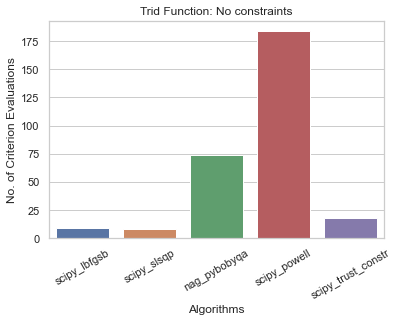

In [67]:
res = {}
for alg in rep_algo_list_trid:
    res[alg] = minimize(
        criterion=trid_dict_criterion,
        params=params,
        algorithm=alg,
        derivative=trid_gradient,
        criterion_and_derivative=trid_criterion_and_gradient,
        logging=False,
    )
    
alg_n_eval = []
for alg in rep_algo_list_trid:
    alg_n_eval.append((alg, res[alg]['n_criterion_evaluations']))

df_alg_n_eval = pd.DataFrame(
        data=alg_n_eval,
    columns=["Algorithms", "No. of Criterion Evaluations"]
)

ax = sns.barplot(x="Algorithms", y="No. of Criterion Evaluations", data=df_alg_n_eval)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
ax.set_title('Trid Function: No constraints')

### Rotated Hyper Ellipsoid

Text(0.5, 1.0, 'Rotated Hyper Ellipsoid Function: No constraints')

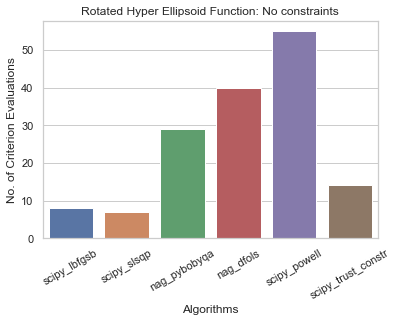

In [68]:
res = {}
for alg in rep_algo_list:
    res[alg] = minimize(
        criterion=rotated_hyper_ellipsoid_dict_criterion,
        params=params,
        algorithm=alg,
        derivative=rotated_hyper_ellipsoid_gradient,
        criterion_and_derivative=rotated_hyper_ellipsoid_criterion_and_gradient,
        logging=False,
    )
    
alg_n_eval = []
for alg in rep_algo_list:
    alg_n_eval.append((alg, res[alg]['n_criterion_evaluations']))

df_alg_n_eval = pd.DataFrame(
        data=alg_n_eval,
    columns=["Algorithms", "No. of Criterion Evaluations"]
)

ax = sns.barplot(x="Algorithms", y="No. of Criterion Evaluations", data=df_alg_n_eval)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
ax.set_title('Rotated Hyper Ellipsoid Function: No constraints')

### Rosenbrock

Text(0.5, 1.0, 'Rosenbrock: No constraints')

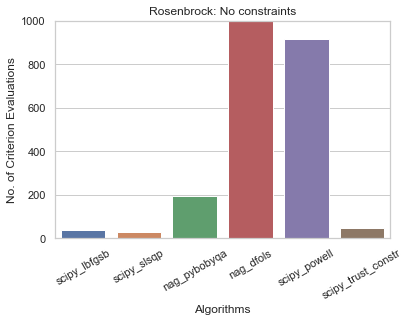

In [69]:
res = {}
for alg in rep_algo_list:
    res[alg] = minimize(
        criterion=rosenbrock_dict_criterion,
        params=params,
        algorithm=alg,
        derivative=rosenbrock_gradient,
        criterion_and_derivative=rosenbrock_criterion_and_gradient,
        logging=False,
    )
alg_n_eval = []
for alg in rep_algo_list:
    alg_n_eval.append((alg, res[alg]['n_criterion_evaluations']))

df_alg_n_eval = pd.DataFrame(
        data=alg_n_eval,
    columns=["Algorithms", "No. of Criterion Evaluations"]
)

ax = sns.barplot(x="Algorithms", y="No. of Criterion Evaluations", data=df_alg_n_eval)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
ax.set(ylim=(0, 1000))
ax.set_title('Rosenbrock: No constraints')

## Case 2: Imposing Equality constraint

In [77]:
params_e = pd.DataFrame(data=[[2], [2], [2]], columns=["value"])
params_e["lower_bound"] = [-5, -5, -5]
params_e["upper_bound"] = -params["lower_bound"]

### Trid

Text(0.5, 1.0, 'Trid Function: Imposing Equality constraint')

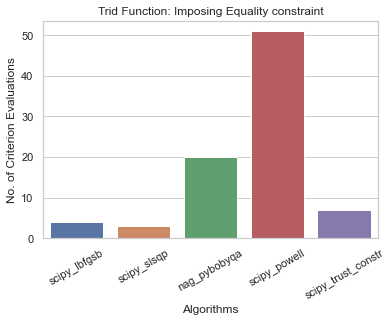

In [78]:
res = {}
for alg in rep_algo_list_trid:
    res[alg] = minimize(
        criterion=trid_dict_criterion,
        params=params_e,
        constraints = [{"loc": [0, 1, 2], "type": "equality"}],
        algorithm=alg,
        criterion_and_derivative=trid_criterion_and_gradient,
        logging=False,
    )
    
alg_n_eval = []
for alg in rep_algo_list_trid:
    alg_n_eval.append((alg, res[alg]['n_criterion_evaluations']))

df_alg_n_eval = pd.DataFrame(
        data=alg_n_eval,
    columns=["Algorithms", "No. of Criterion Evaluations"]
)

ax = sns.barplot(x="Algorithms", y="No. of Criterion Evaluations", data=df_alg_n_eval)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
ax.set_title('Trid Function: Imposing Equality constraint')

### Rotated Hyper Ellipsoid

Text(0.5, 1.0, 'Rotated Hyper Ellipsoid Function: Imposing Equality constraint')

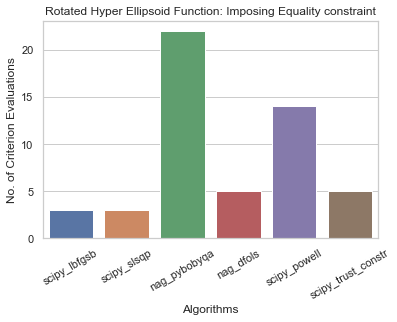

In [79]:
res = {}
for alg in rep_algo_list:
    res[alg] = minimize(
        criterion=rotated_hyper_ellipsoid_dict_criterion,
        params=params_e,
        constraints = [{"loc": [0, 1, 2], "type": "equality"}],
        algorithm=alg,
        criterion_and_derivative=rotated_hyper_ellipsoid_criterion_and_gradient,
        logging=False,
    )
    
alg_n_eval = []
for alg in rep_algo_list:
    alg_n_eval.append((alg, res[alg]['n_criterion_evaluations']))

df_alg_n_eval = pd.DataFrame(
        data=alg_n_eval,
    columns=["Algorithms", "No. of Criterion Evaluations"]
)

ax = sns.barplot(x="Algorithms", y="No. of Criterion Evaluations", data=df_alg_n_eval)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
ax.set_title('Rotated Hyper Ellipsoid Function: Imposing Equality constraint')

### Rosenbrock

Text(0.5, 1.0, 'Rosenbrock Function: Imposing Equality constraint')

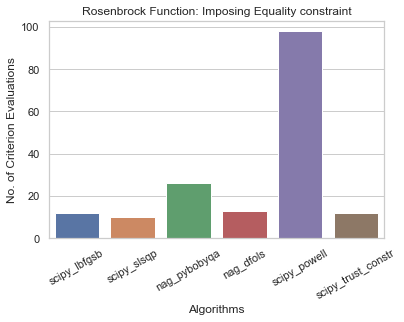

In [80]:
res = {}
for alg in rep_algo_list:
    res[alg] = minimize(
        criterion=rosenbrock_dict_criterion,
        params=params_e,
        constraints = [{"loc": [0, 1, 2], "type": "equality"}],
        algorithm=alg,
        criterion_and_derivative=rosenbrock_criterion_and_gradient,
        logging=False,
    )
    
alg_n_eval = []
for alg in rep_algo_list:
    alg_n_eval.append((alg, res[alg]['n_criterion_evaluations']))

df_alg_n_eval = pd.DataFrame(
        data=alg_n_eval,
    columns=["Algorithms", "No. of Criterion Evaluations"]
)

ax = sns.barplot(x="Algorithms", y="No. of Criterion Evaluations", data=df_alg_n_eval)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
ax.set_title('Rosenbrock Function: Imposing Equality constraint')

Recall that scipy_lbfgsb fails to find the optima for the rosenbrock-equality-constraint case.

## Case 3: Imposing Linear constraint

In [82]:
params_l = pd.DataFrame(data=[[2], [1], [3]], columns=["value"])

### Trid

Text(0.5, 1.0, 'Trid Function: Imposing Linear constraint')

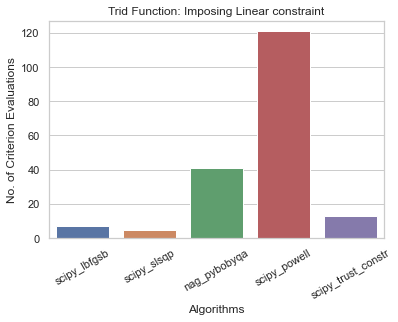

In [84]:
res = {}
for alg in rep_algo_list_trid:
    res[alg] = minimize(
        criterion=trid_dict_criterion,
        params=params_l,
        constraints = [{"loc": [0, 1], "type": "linear", "value": 4, "weights": [1, 2]}],
        algorithm=alg,
        criterion_and_derivative=trid_criterion_and_gradient,
        logging=False,
    )
    
alg_n_eval = []
for alg in rep_algo_list_trid:
    alg_n_eval.append((alg, res[alg]['n_criterion_evaluations']))

df_alg_n_eval = pd.DataFrame(
        data=alg_n_eval,
    columns=["Algorithms", "No. of Criterion Evaluations"]
)

ax = sns.barplot(x="Algorithms", y="No. of Criterion Evaluations", data=df_alg_n_eval)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
ax.set_title('Trid Function: Imposing Linear constraint')

### Rotated Hyper Ellipsoid

Text(0.5, 1.0, 'Rotated Hyper Ellipsoid Function: Imposing Linear constraint')

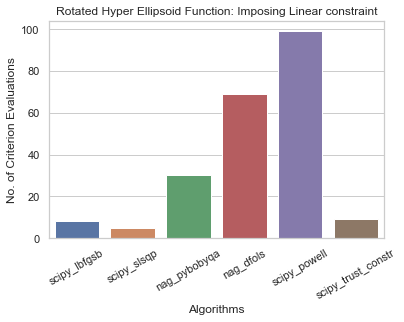

In [85]:
res = {}
for alg in rep_algo_list:
    res[alg] = minimize(
        criterion=rotated_hyper_ellipsoid_dict_criterion,
        params=params_l,
        constraints = [{"loc": [0, 1], "type": "linear", "value": 4, "weights": [1, 2]}],
        algorithm=alg,
        criterion_and_derivative=rotated_hyper_ellipsoid_criterion_and_gradient,
        logging=False,
    )
    
alg_n_eval = []
for alg in rep_algo_list:
    alg_n_eval.append((alg, res[alg]['n_criterion_evaluations']))

df_alg_n_eval = pd.DataFrame(
        data=alg_n_eval,
    columns=["Algorithms", "No. of Criterion Evaluations"]
)

ax = sns.barplot(x="Algorithms", y="No. of Criterion Evaluations", data=df_alg_n_eval)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
ax.set_title('Rotated Hyper Ellipsoid Function: Imposing Linear constraint')

### Rosenbrock

Text(0.5, 1.0, 'Rosenbrock Function: Imposing Linear constraint')

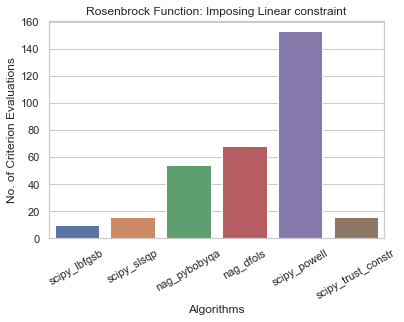

In [86]:
res = {}
for alg in rep_algo_list:
    res[alg] = minimize(
        criterion=rosenbrock_dict_criterion,
        params=params_l,
        constraints = [{"loc": [0, 1], "type": "linear", "value": 4, "weights": [1, 2]}],
        algorithm=alg,
        criterion_and_derivative=rosenbrock_criterion_and_gradient,
        logging=False,
    )
    
alg_n_eval = []
for alg in rep_algo_list:
    alg_n_eval.append((alg, res[alg]['n_criterion_evaluations']))

df_alg_n_eval = pd.DataFrame(
        data=alg_n_eval,
    columns=["Algorithms", "No. of Criterion Evaluations"]
)

ax = sns.barplot(x="Algorithms", y="No. of Criterion Evaluations", data=df_alg_n_eval)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
ax.set_title('Rosenbrock Function: Imposing Linear constraint')

---
<a id='sec5'></a>
# 5. Summary of contributions
---